In [55]:
import polars as pl
import pandas as pd
import altair as alt
from pathlib import Path
from darts import TimeSeries
from darts.models import ARIMA
from matplotlib import pyplot as plt
plt.style.use("default")

alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
data_dir = Path("data")
df = pl.read_parquet(data_dir / "DSU-Dataset.parquet")

In [3]:
df = df.drop(
    "Claim ID", "Patient ID"
)  # we don't need these columns because they are unique identifiers are do not contain any useful information
df.describe()

statistic,Service Date,Recieved Date,Paid Date,Member Age,Gender,Marital Status,Ethnicity,LOB,Network Status,Claim Category,Claim Subcategory,Claim Line,Place of Service,Provider Type,Provider Specialty,ICD10 Code 1,ICD10 Code 2,ICD10 Code 3,ICD10 Code 4,ICD10 Code 5,ICD10 Code 6,ICD10 Code 7,ICD10 Code 8,ICD10 Code 9,ICD10 Code 10,Service Type,Service Code,Modifiers,High Cost Claim
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64
"""count""","""253686""","""253686""","""253686""","""253686""","""253686""","""241000""","""226800""","""253686""","""253686""","""253685""","""253685""","""253686""","""253686""","""253671""","""253685""",252750.0,176154.0,127472.0,95637.0,69465.0,56029.0,45262.0,37466.0,31514.0,26932.0,"""253686""","""253686""","""78847""",203250.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""12686""","""26886""","""0""","""0""","""1""","""1""","""0""","""0""","""15""","""1""",936.0,77532.0,126214.0,158049.0,184221.0,197657.0,208424.0,216220.0,222172.0,226754.0,"""0""","""0""","""174839""",50436.0
"""mean""","""2023-07-08 10:53:11.050000""","""2023-08-02 17:14:36.223000""","""2023-08-10 09:56:13.685000""",null,null,null,null,null,null,null,null,null,null,null,null,1458.673737,1357.81938,1332.740908,1424.046927,1446.2149,1533.74324,1541.26541,1650.423744,1555.836612,1755.552391,null,null,null,0.072315
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2224.261383,2053.669316,2098.782557,2170.225435,2130.954839,2224.144934,2267.625474,2383.157005,2272.372021,2408.165582,null,null,null,0.259009
"""min""","""2021-12-03""","""2021-12-06""","""2021-12-12""","""1-9 Yrs Old""","""F""","""Divorced""","""African American/Black""","""BES""","""IN NETWORK""","""HOSPICE""","""ACUTE INPATIENT""","""MEDICAL""","""AMBULANCE - AIR OR WATER""","""ACUPUNCTURIST""","""ACUPUNCTURIST""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""DRG""","""0001A""","""22""",0.0
"""25%""","""2022-10-08""","""2022-11-01""","""2022-11-09""",null,null,null,null,null,null,null,null,null,null,null,null,118.0,122.0,97.0,137.0,173.0,188.0,194.0,199.0,202.0,219.0,null,null,null,0.0
"""50%""","""2023-07-20""","""2023-08-14""","""2023-08-22""",null,null,null,null,null,null,null,null,null,null,null,null,539.0,541.0,486.0,519.0,580.0,622.0,629.0,741.0,622.0,796.0,null,null,null,0.0
"""75%""","""2024-04-15""","""2024-05-17""","""2024-05-25""",null,null,null,null,null,null,null,null,null,null,null,null,1696.0,1561.0,1467.0,1648.0,1673.0,1837.0,1776.0,1912.0,1742.0,2104.0,null,null,null,0.0
"""max""","""2025-01-05""","""2025-01-09""","""2025-01-12""","""< 1 Yrs Old""","""U""","""Widowed""","""Unavailable/Unknown""","""WRH""","""TIER 1""","""PROFESSIONAL""","""URGENT CARE""","""PHARMACY""","""WALK-IN RETAIL HEALTH CLINIC""","""Student Registered Nurse Anest…","""VASCULAR SURGERY (SURGERY)""",11323.0,11327.0,11316.0,11322.0,11271.0,11328.0,11325.0,11279.0,11212.0,11289.0,"""REV""","""V5275""","""XU,RT""",1.0


In [4]:
relevant_columns = [
    "Member Age",
    "Gender",
    "Marital Status",
    "Ethnicity",
    "LOB",
    "Network Status",
    "Claim Category",
    "Claim Subcategory",
    "Claim Line",
    "Place of Service",
    "Provider Type",
    "Provider Specialty",
    "Service Code",
    "Modifiers"
]

for column in relevant_columns:
    print(df.select(column).unique())

shape: (12, 1)
┌───────────────┐
│ Member Age    │
│ ---           │
│ str           │
╞═══════════════╡
│ 50-59 Yrs Old │
│ 1-9 Yrs Old   │
│ 40-49 Yrs Old │
│ 90-99 Yrs Old │
│ < 1 Yrs Old   │
│ …             │
│ 20-29 Yrs Old │
│ 70-79 Yrs Old │
│ 10-19 Yrs Old │
│ 60-69 Yrs Old │
│ 100+ Yrs Old  │
└───────────────┘
shape: (3, 1)
┌────────┐
│ Gender │
│ ---    │
│ str    │
╞════════╡
│ M      │
│ F      │
│ U      │
└────────┘
shape: (9, 1)
┌───────────────────┐
│ Marital Status    │
│ ---               │
│ str               │
╞═══════════════════╡
│ Unknown           │
│ Single            │
│ Other             │
│ null              │
│ Widowed           │
│ Married           │
│ Partnered         │
│ Legally Separated │
│ Divorced          │
└───────────────────┘
shape: (12, 1)
┌─────────────────────────────────┐
│ Ethnicity                       │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ African American/Black   

In [5]:
df = df.filter(pl.col("High Cost Claim").is_not_null()) # remove rows with missing values in the target column

In [6]:
df.sample(10)

Service Date,Recieved Date,Paid Date,Member Age,Gender,Marital Status,Ethnicity,LOB,Network Status,Claim Category,Claim Subcategory,Claim Line,Place of Service,Provider Type,Provider Specialty,ICD10 Code 1,ICD10 Code 2,ICD10 Code 3,ICD10 Code 4,ICD10 Code 5,ICD10 Code 6,ICD10 Code 7,ICD10 Code 8,ICD10 Code 9,ICD10 Code 10,Service Type,Service Code,Modifiers,High Cost Claim
date,date,date,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64
2022-05-06,2022-05-17,2022-05-24,"""60-69 Yrs Old""","""F""","""Married""",null,"""NPR""","""ND PERS PPO""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Certified Nurse Practitioner""","""NP - FAMILY MEDICINE""",466,5,1444,1302,null,null,null,null,null,null,"""PROC""","""90715""",null,0
2022-12-01,2022-12-15,2022-12-18,"""1-9 Yrs Old""","""M""","""Single""","""Caucasian/White""","""COM""","""IN NETWORK""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Physician""","""PEDIATRICS""",241,52,null,null,null,null,null,null,null,null,"""PROC""","""99213""","""25""",0
2022-08-18,2022-08-25,2022-09-01,"""60-69 Yrs Old""","""M""","""Married""","""Caucasian/White""","""COX""","""IN NETWORK""","""OUTPATIENT""","""OUTPATIENT""","""PHARMACY""","""ON CAMPUS - OUTPATIENT HOSPITA…","""Resource""","""ACUTE CARE HOSPITAL (GENERAL)""",1129,5631,260,null,null,null,null,null,null,null,"""PROC""","""J2270""","""UD""",0
2022-07-10,2022-08-04,2022-08-07,"""60-69 Yrs Old""","""M""","""Married""","""Caucasian/White""","""COX""","""IN NETWORK""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Physical Therapist""","""PHYSICAL THERAPIST""",38,899,null,null,null,null,null,null,null,null,"""PROC""","""97162""",null,0
2023-07-20,2023-07-26,2023-08-01,"""10-19 Yrs Old""","""F""","""Single""","""American Indian or Alaskan Nat…","""SGH""","""IN NETWORK""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Counselor""","""COUNSELOR""",1302,null,null,null,null,null,null,null,null,null,"""PROC""","""90837""",null,0
2024-09-16,2024-09-17,2024-09-24,"""1-9 Yrs Old""","""M""","""Single""","""Unavailable/Unknown""","""NPS""","""ND PERS PPO""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Physician""","""PEDIATRICS""",1820,null,null,null,null,null,null,null,null,null,"""PROC""","""99213""",null,0
2022-03-30,2022-04-21,2022-04-29,"""60-69 Yrs Old""","""M""","""Married""","""Caucasian/White""","""NPM""","""ND PERS PPO""","""OUTPATIENT""","""EMERGENCY""","""MEDICAL""","""EMERGENCY ROOM - HOSPITAL""","""Resource""","""ACUTE CARE HOSPITAL (GENERAL)""",911,2302,179,755,1776,779,621,null,null,null,"""PROC""","""84484""",null,0
2024-02-25,2024-03-06,2024-03-14,"""20-29 Yrs Old""","""F""","""Single""","""Caucasian/White""","""NPS""","""ND PERS PPO""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Doctor Of Chiropractic""","""CHIROPRACTOR""",33,97,35,34,9859,93,411,995,182,null,"""PROC""","""98940""",null,0
2021-12-28,2021-12-30,2022-01-07,"""30-39 Yrs Old""","""F""","""Single""","""Caucasian/White""","""NPS""","""ND PERS PPO""","""PROFESSIONAL""","""OFFICE VISIT""","""MEDICAL""","""OFFICE""","""Physician""","""FAMILY MEDICINE""",673,346,1214,1215,23,14,null,null,null,null,"""PROC""","""87624""","""90""",0


In [7]:
print(df.filter(pl.col("High Cost Claim") == 1).count())
print(df.filter(pl.col("High Cost Claim") == 0).count())

shape: (1, 29)
┌─────────┬─────────────────┬───────┬────────┬───┬─────────┬─────────┬───────────┬─────────────────┐
│ Service ┆ Recieved Date   ┆ Paid  ┆ Member ┆ … ┆ Service ┆ Service ┆ Modifiers ┆ High Cost Claim │
│ Date    ┆ ---             ┆ Date  ┆ Age    ┆   ┆ Type    ┆ Code    ┆ ---       ┆ ---             │
│ ---     ┆ u32             ┆ ---   ┆ ---    ┆   ┆ ---     ┆ ---     ┆ u32       ┆ u32             │
│ u32     ┆                 ┆ u32   ┆ u32    ┆   ┆ u32     ┆ u32     ┆           ┆                 │
╞═════════╪═════════════════╪═══════╪════════╪═══╪═════════╪═════════╪═══════════╪═════════════════╡
│ 14698   ┆ 14698           ┆ 14698 ┆ 14698  ┆ … ┆ 14698   ┆ 14698   ┆ 784       ┆ 14698           │
└─────────┴─────────────────┴───────┴────────┴───┴─────────┴─────────┴───────────┴─────────────────┘
shape: (1, 29)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Service   ┆ Recieved  ┆ Paid Date ┆ Member    ┆ … ┆ Service

In [8]:
time_claim = df.select("Service Date", "High Cost Claim")
time_claim.with_columns(time_claim["Service Date"].cast(pl.Date)).sort("Service Date")
time_claim = time_claim.group_by("Service Date").agg(pl.sum("High Cost Claim").alias("High Cost Claim"))
time_claim.plot.line(x="Service Date", y="High Cost Claim").properties(width=1200, height=600)

alt.Chart(...)

In [30]:
dummies_columns = [
    "Member Age",
    "Gender",
    "Marital Status",
    "Ethnicity",
    "LOB",
    "Network Status",
    "Claim Category",
    "Claim Subcategory",
    "Claim Line",
    "Place of Service",
    "Provider Type",
    "Provider Specialty",
]
df_dummies = df.drop("Modifiers", "Recieved Date", "Paid Date", "ICD10 Code 1", "ICD10 Code 2", "ICD10 Code 3", "ICD10 Code 4", "ICD10 Code 5", "ICD10 Code 6", "ICD10 Code 7", "ICD10 Code 8", "ICD10 Code 9", "ICD10 Code 10")
df_dummies = df_dummies.to_dummies(columns=dummies_columns)
# now sum all columns and group by Service Date
df_dummies_cols = df_dummies.columns
df_dummies_cols.remove("Service Date")
df_dummies = df_dummies.group_by("Service Date").agg(pl.sum(df_dummies_cols)).sort("Service Date")
# df_dummies.describe()
df_dummies_pd = df_dummies.to_pandas()
df_dummies_timeseries = TimeSeries.from_dataframe(df_dummies_pd, time_col="Service Date", value_cols=["High Cost Claim"], freq="D", fill_missing_dates=False)

c:\Users\DSU Student\Documents\DSU-Data-Competition-Spring2025\.venv\lib\site-packages\darts\timeseries.py:734: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


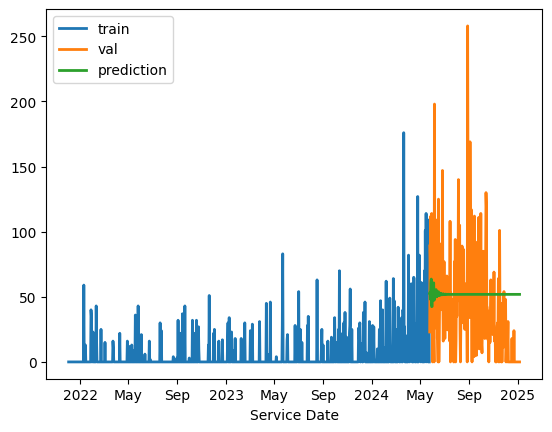

In [58]:
model = ARIMA()
train, val = df_dummies_timeseries.split_after(0.8)
model.fit(train)
prediction = model.predict(len(val))
train.plot(label="train")
val.plot(label="val")
prediction.plot(label="prediction")
# prediction.values()
plt.legend()